# Introduction

L'objectif de ce notebook est de construire un modèle permettant de prédire la variable `TotalGHGEmissions`.

La démarche est très similaire avec celle mise en place pour `SiteEnergyUseWN(kBtu)` car les deux variables sont très corrélées.<br>
On ira présentera donc cette fois directement l'essentiel : un préprocesseur efficace et d'une sélection de features pertinente.<br>
Quelques itérations ont tout de même été nécessaires pour vérifier qu'il s'agissait bien d'une solution optimale.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer, TransformedTargetRegressor

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, TargetEncoder, FunctionTransformer

from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time
import shap

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import RobustScaler
from category_encoders import TargetEncoder as MeanEncoder
from sklearn.model_selection import cross_val_score

In [34]:
data = pd.read_csv("csv/filtered_data.csv")

df = data.drop("SiteEnergyUseWN(kBtu)", axis = 1)
target = "TotalGHGEmissions"

In [35]:
def display_dimensions(df) :
    print(f"Dimensions du dataset :")
    print("  -", df.shape[0], "lignes")
    print("  -", df.shape[1], "colonnes")
    
display_dimensions(df)

Dimensions du dataset :
  - 1621 lignes
  - 26 colonnes


# Modélisation

In [36]:
models = {
    "Linear Regression" : LinearRegression(),
    "Gradient Boost" : GradientBoostingRegressor(),
    "Random Forest" : RandomForestRegressor(),
    "SVR" : SVR(),
    "Elastic Net" : ElasticNet(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(verbosity = 0)
}

In [37]:
def cross_evaluate(model_name, model, preprocessor, X, y) :
    
    pipeline = Pipeline(steps = [
        ("preprocessor", preprocessor),
        (model_name, model)
    ])

    start_time = time.time()
    scores = cross_val_score(pipeline, X, y, cv = 5, scoring = "r2", n_jobs = -1)
    cv_time = time.time() - start_time

    result = {"Model" : model_name,
                "Time" : str(round(cv_time * 1000)) + " ms",
                "Score" : round(np.mean(scores), 4)}
        
    for i in range(5) :
        result["Fold_" + str(i + 1)] = round(scores[i], 4)
        
    return result

In [38]:
def cross_evaluate_all(models, preprocessor, X, y, log_target = False) :
    
    results = []
    
    for model_name, model in models.items() :
    
        if log_target :
            model = TransformedTargetRegressor(
                regressor = model,
                transformer = FunctionTransformer(func = np.log1p, inverse_func = np.expm1),
            )
        
        results.append(cross_evaluate(model_name, model, preprocessor, X, y))
        
    return pd.DataFrame(results).set_index("Model")

In [39]:
median_imputer_features = ['PropertyGFATotal', 'PropertyGFABuilding(s)',
                           'Longitude', 'Latitude', 'LargestPropertyUseTypeGFA']

zero_filler_features = ['GasRatio', 'ElectricityRatio', 'SteamRatio',
                        'SecondLargestPropertyUseTypeGFA']

target_encoder_features = ['PrimaryPropertyType', 'CouncilDistrictCode', 'NumberofFloors', 'NumberofBuildings',
                           'LargestPropertyUseType', 'SecondLargestPropertyUseType']

zero_filler = make_pipeline(SimpleImputer(strategy = "constant", fill_value = 0), RobustScaler())

median_imputer = make_pipeline(SimpleImputer(strategy = "median"), RobustScaler())

target_encoder = make_pipeline(SimpleImputer(strategy = "constant", fill_value = "None"), TargetEncoder(), RobustScaler())

preprocessor = ColumnTransformer(transformers = [
    ("median_imputer", median_imputer, median_imputer_features),
    ("zero_filler", zero_filler, zero_filler_features),
    ("target_encoder", target_encoder, target_encoder_features)
])

In [40]:
selected_features = median_imputer_features + zero_filler_features + target_encoder_features

X = df[selected_features].copy()
y = df[target].copy()

cross_evaluate_all(models, preprocessor, X, y)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,58 ms,0.2668,0.3995,0.5418,0.1881,0.5485,-0.3438
Gradient Boost,1009 ms,0.7486,0.5330,0.8581,0.7660,0.8356,0.7502
Random Forest,3884 ms,0.6920,0.5352,0.8021,0.8081,0.8214,0.4935
SVR,178 ms,-0.0027,-0.0694,-0.0097,0.0383,0.0395,-0.0122
Elastic Net,58 ms,0.4724,0.2915,0.5042,0.5081,0.6891,0.3694
XGBoost,342 ms,0.7357,0.7077,0.9108,0.7815,0.8471,0.4314
LightGBM,527 ms,0.6089,0.2746,0.5860,0.8049,0.7791,0.5999


Il était demandé dans le projet de déterminer l'impact de l'ENERGYSTARScore.

In [41]:
median_imputer_features.append("ENERGYSTARScore")
selected_features.append("ENERGYSTARScore")

X = df[selected_features].copy()
y = df[target].copy()

cross_evaluate_all(models, preprocessor, X, y)

,Time,Score,Fold_1,Fold_2,Fold_3,Fold_4,Fold_5
Model,,,,,,,
Linear Regression,93 ms,0.2932,0.4147,0.5420,0.1826,0.5089,-0.1820
Gradient Boost,1085 ms,0.7475,0.6194,0.8516,0.7375,0.8077,0.7213
Random Forest,3994 ms,0.6923,0.4921,0.7755,0.8464,0.7746,0.5728
SVR,181 ms,0.0046,-0.0709,-0.0129,0.0471,0.0389,0.0208
Elastic Net,47 ms,0.4651,0.3065,0.5200,0.5130,0.6632,0.3228
XGBoost,379 ms,0.7646,0.6331,0.8997,0.7924,0.8663,0.6313
LightGBM,460 ms,0.6002,0.2754,0.5923,0.7649,0.8094,0.5587


Les résultats sont sensiblement identiques avec ou sans l'ENERGYSTARScore.<br>
S'il est fastidieux à obtenir sur le terrain, autant s'en passer.

# Recherche d'hyperparamètres

In [42]:
def grid_search(model, preprocessor, param_grid, X, y, verbose = 0) :
       
    pipeline = make_pipeline(preprocessor, RobustScaler(), model)
    grid_search = GridSearchCV(estimator = pipeline, param_grid = param_grid, scoring = "r2", cv = 10, verbose = verbose)
    results = grid_search.fit(X, y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_
      
    print("\n--- Hyperparamètres ---")
    for (param, value) in best_params.items() :
        print(param, ":", value)
        
    return best_model

In [20]:
param_grid = {"randomforestregressor__n_estimators" : [200],
              "randomforestregressor__max_features" : [2, 4, 6],
              "randomforestregressor__min_samples_split" : [2, 4, 8],
              "randomforestregressor__bootstrap": [True, False]}

best_model = grid_search(RandomForestRegressor(n_jobs = -1), preprocessor, param_grid, X, y, verbose = 1)

Fitting 10 folds for each of 18 candidates, totalling 180 fits

--- Hyperparamètres ---
randomforestregressor__bootstrap : False
randomforestregressor__max_features : 4
randomforestregressor__min_samples_split : 2
randomforestregressor__n_estimators : 200


In [43]:
pipeline_rf = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(n_jobs = -1,
                                 bootstrap = False,
                                 max_features = 4,
                                 min_samples_split = 2,
                                 n_estimators = 1000))
])

scores_rg = cross_val_score(pipeline_rf, X, y, cv = 5, scoring = "r2", n_jobs = -1)
print("Random Forest average score :", np.mean(scores_rg))

Random Forest average score : 0.7170618349512905


In [13]:
param_grid = {"gradientboostingregressor__n_estimators" : [50, 100, 200],
              "gradientboostingregressor__learning_rate" : [0.05, 0.1, 0.2],
              "gradientboostingregressor__max_depth" : [3, 4, 5]}

best_model = grid_search(GradientBoostingRegressor(), preprocessor, param_grid, X, y, verbose = 1)

Fitting 10 folds for each of 27 candidates, totalling 270 fits

--- Hyperparamètres ---
gradientboostingregressor__learning_rate : 0.2
gradientboostingregressor__max_depth : 3
gradientboostingregressor__n_estimators : 100


In [44]:
pipeline_gb = Pipeline(steps = [
    ("preprocessor", preprocessor),
    ("gb", GradientBoostingRegressor(n_estimators = 1000,
                                      learning_rate = 0.2,
                                      max_depth = 3))
])

scores_gb = cross_val_score(pipeline_gb, df, y, cv = 5, scoring = "r2", n_jobs = -1)
print("Gradient Boost average score :", np.mean(scores_gb))

Gradient Boost average score : 0.7386727317621725


Cette fois c'est le Gradient Boost qui obtient un score légèrement meilleur : on le choisit comme modèle final.

# Feature importance

Maintenant que le modèle final est prêt, on l'entraîne le sur un jeu d'entraînement puis on prédit sur un jeu de test afin d'accéder à la feature importance.

In [50]:
def get_feature_names(column_transformer) :
    
    def get_names(trans) :
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)) :
            return []
        if trans == 'passthrough' :
            if hasattr(column_transformer, '_df_columns') :
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)) :
                    return column
                else :
                    return column_transformer._df_columns[column]
            else :
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names') :
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            if column is None :
                return []
            else:
                return [name + "__" + f for f in column]

        return [str(name) + "__" + str(f) for f in trans.get_feature_names()]
    
    # Début du prétraitement
    feature_names = []
    if type(column_transformer) == Pipeline :
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else :
        l_transformers = list(column_transformer._iter(fitted=True))
    
    for name, trans, column, _ in l_transformers :
        if type(trans) == Pipeline :
            _names = get_feature_names(trans)
            if len(_names) == 0 :
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else :
            feature_names.extend(get_names(trans))
    
    return feature_names

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

gbr = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.2, max_depth = 3)
pipeline = make_pipeline(preprocessor, gbr)
pipeline.fit(X_train, y_train)

feature_importances = gbr.feature_importances_
indices = (-feature_importances).argsort()

In [52]:
import re

feature_names = get_feature_names(preprocessor)
cleaned_feature_names = [re.split('__', name, 1)[1] for name in feature_names]
top_n = len(cleaned_feature_names)
sorted_feature_names = [cleaned_feature_names[i] for i in indices[:top_n]]

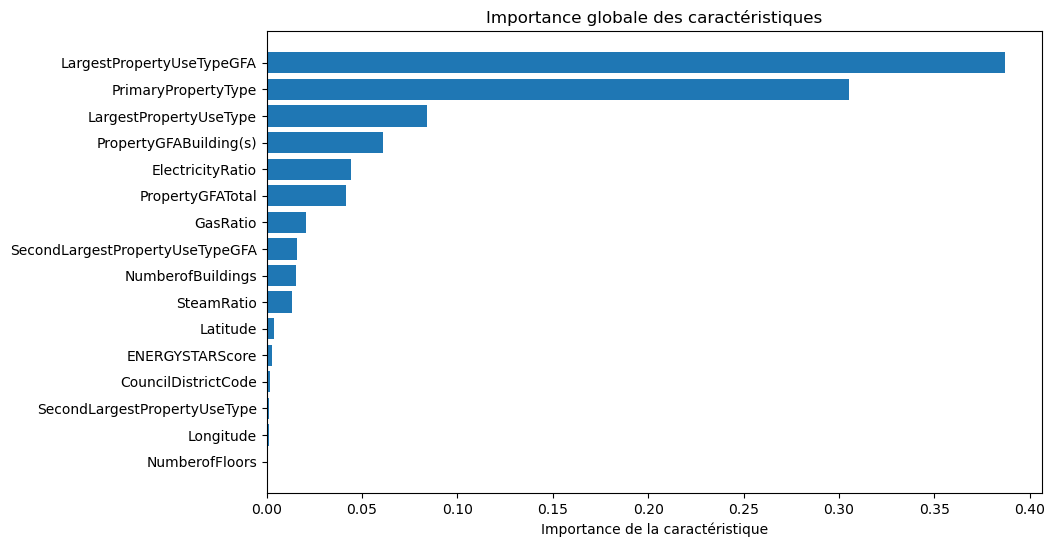

In [53]:
plt.figure(figsize=(10, 6))
plt.barh(range(top_n), feature_importances[indices[:top_n]], align="center")
plt.yticks(range(top_n), sorted_feature_names)
plt.xlabel("Importance de la caractéristique")
plt.title("Importance globale des caractéristiques")
plt.gca().invert_yaxis()
plt.show()

On retrouve que la feature importance de l'ENERGYSTARScore est très faible.

Finalement, entraînons le modèle sur l'intégralité des données pour le préparer au mieux à la réaliation de prédictions sur de futures données.

In [54]:
best_model = GradientBoostingRegressor(n_estimators = 1000, learning_rate = 0.2, max_depth = 3)

final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", best_model)
])

final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('median_imputer',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['PropertyGFATotal',
                                                   'PropertyGFABuilding(s)',
                                                   'Longitude', 'Latitude',
                                                   'LargestPropertyUseTypeGFA',
                                                   'ENERGYSTARScore']),
                                                 ('zero_filler',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   Sim...
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='None',
                                                                                 strategy='constant')),
                                                                  ('targetencoder',
                                                                   TargetEncoder()),
                                                                  ('robustscaler',
                                                                   RobustScaler())]),
                                                  ['PrimaryPropertyType',
                                                   'CouncilDistrictCode',
                                                   'NumberofFloors',
                                                   'NumberofBuildings',
                                                   'LargestPropertyUseType',
                                                   'SecondLargestPropertyUseType'])])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.2,
                                           n_estimators=1000))])